# Main analysis tACS OPM data

In [103]:
import numpy as np
import pyxdf
import matplotlib.pyplot as plt
from scipy import signal, fftpack
from scipy.signal import hilbert, butter, filtfilt

import mne 
from mne.time_frequency import psd_welch

## check no-TACS data 

In [104]:
## import no-tacs data

data, header=  pyxdf.load_xdf('../recordings/02_06/P06-tacs-R1.xdf')

if data[0]['info']['name'][0] == 'ExperimentMarkers': 
    markers_data = data[0] 
    opm_data = data[1]
else: 
    markers_data = data[1]   
    opm_data = data[0]

fs = 1000 # sampling rate 

opm_time_stamps = opm_data['time_stamps'] 


# plt.figure(figsize=(15,10))
# plt.plot(markers_data['time_stamps'][:40], markers_data['time_series'][:40])



In [105]:
## set up the markers information
marker_id_start = 7
marker_id_end = 9
marker_id_trial_end = 2
marker_id_trial_start = 1

markers_data_ts = markers_data['time_stamps']

# get the approximate index in chassis time stamp for start trigger
start_marker = markers_data_ts[np.where(markers_data['time_series'].flatten() == marker_id_start)[0]][0]
diff = start_marker - opm_time_stamps 
diff_bool = (diff < 0.001) & (diff > 0) 
start_marker_index = np.where(opm_time_stamps == opm_time_stamps[diff_bool])[0][0] 

# get the approximate index in chassis time stamp for end trigger
end_marker = markers_data_ts[np.where(markers_data['time_series'].flatten() == marker_id_end)[0]][0]
diff = end_marker - opm_time_stamps 
diff_bool = (diff < 0.001) & (diff > 0) 
end_marker_index = np.where(opm_time_stamps == opm_time_stamps[diff_bool])[0][0]
num_trials = int((markers_data['time_series'].flatten().shape[0] - 2)/ 2) # divide by two because of start and end markers 


#make epochs time stamps in chassis time
markers_data_cut = markers_data['time_series'].flatten()[1:-1] # remove start and end marker timestamps
markers_data_ts = markers_data_ts[1:-1] #remove start and end marker


index = 1
index_1 = 0 #for feeding epochs_ts


start_markers_ts = markers_data_ts[np.where(markers_data_cut == 1)[0]]
# for ts in markers_data_ts: 
#     epochs_ts[index_1] = ts

epochs_ts_index = np.zeros_like(start_markers_ts, dtype=int) #for start and end
for i, ts in enumerate(start_markers_ts): 
    diff = ts - opm_time_stamps 
    diff_bool = (diff < 0.001) & (diff > 0) 
    epochs_ts_index[i] = np.where(opm_time_stamps == opm_time_stamps[diff_bool])[0][0]



In [106]:
## setting up the raw time series data for processing 

adc_diode_idx = 11
# adc_tacs_idx = 0
## There will be _full and _cut, the difference is in the duration cut.
opm_data_full = opm_data['time_series'][:] * 1e-15 #in tesla

# adc_diode_full = opm_data_full[:, adc_diode_idx]

# opm_data_full = np.delete(opm_data_full, adc_diode_idx, 1)

num_channels_w_adcs = opm_data['time_series'][:].shape[1]
num_samples = opm_data_full.shape[0]

# print("Time left in cut raw: %f s" %(opm_data_cut.shape[0]/fs))

# channel names according to the order of the OPM data without the ADCs
channel_names = np.zeros(shape=[num_channels_w_adcs], dtype='object') 
channel_types = np.zeros(shape=[num_channels_w_adcs], dtype='object')
channel_units = np.zeros(shape=[num_channels_w_adcs], dtype='object')
for i, channel in enumerate(opm_data['info']['desc'][0]['channels'][0]['channel']):
    # print(channel)
    channel_names[i] = channel['label'][0]
    channel_types[i] = channel['type'][0]
    channel_units[i] = channel['unit'][0]

# channel_names = np.delete(channel_names, adc_diode_idx)

# channel_types = np.delete(channel_types, adc_diode_idx)


## channels ordering
ref_channels = ['01:01:50', '01:02:50', '01:05:50']

tACS_channel = ['00:00:0']
photodiode_channel = ['01:00:0']


channel_orders = ['00:12:50','00:08:50', '01:04:50'
, '00:11:50', '00:07:50', '01:03:50'
, '00:10:50', '00:06:50', '00:03:50'
, '00:09:50', '00:05:50', '00:01:50']


## create full time-series of the adc_diode

# # checking the flicker timing recorded by the photodiode on the projector
# threshold = min(adc_diode_full) + (max(adc_diode_full) - min(adc_diode_full)) * 0.65


# adc_diode_square = np.where(adc_diode_full > threshold, 1, 0) #square signal
# adc_diode_markers = np.where(adc_diode_full > threshold, 1, 0) # vertical lines


# on = False
# for idx, x in enumerate(adc_diode_square): 
#     if x==1 and not on: ## if this is the first one
#         on = True
#     elif x==1 and on: ## during the on period.
#         adc_diode_square[idx] = 1
#         adc_diode_markers[idx] = 0
#         if idx+1==adc_diode_square.shape[0] or adc_diode_square[idx+1] == 0: ## if this is the last one
#             adc_diode_square[idx] = 0
#             adc_diode_markers[idx] = 1
#             on = False

# # get the timing on between flickers. It should be 0.1 s interval (10hz flicker) + random ITI 
# index_diode_on = np.where(adc_diode_markers == 1)[0] 
# timing_diode = np.diff(opm_time_stamps[index_diode_on])

# ## create a phase time series of the ADC diode (visual stimuli)
# adc_diode_phase = np.angle(hilbert(adc_diode_square), deg=False)

# plt.plot(adc_diode_square[20000:23000])




## another thing, make a title

In [107]:
##make epochs for OPM data and 


#make mne object, maybe for easier filtering or other pre-processing stuff..
info = mne.create_info(list(channel_names), fs, list(channel_types))
raw = mne.io.RawArray(opm_data_full[:].T, info)

## TODO: Look into the reference channels
ref = raw.copy().pick(ref_channels)
raw.drop_channels(ref_channels)
#get the tACS and photodiode mne raw data
raw_tacs = raw.copy().pick_channels(tACS_channel)
raw_photodiode = raw.copy().pick_channels(photodiode_channel)
# raw will only be left with primary channels only
raw.drop_channels(tACS_channel)
raw.drop_channels(photodiode_channel)

raw.reorder_channels(channel_orders)

raw_fil_10 = raw.copy().filter(9,11)
raw_fil_1_30 = raw.copy().filter(1,30)

raw_arr_f10 = raw_fil_10[:][0]
raw_arr_f1_30 = raw_fil_1_30[:][0]
print(raw_arr_f1_30.shape)

num_primary_channels = raw_arr_f10.shape[0] # exlcuding reference and adc

trial_dur = 2000 #2 seconds trial
epo_opm_f10 = np.zeros(shape=[num_primary_channels, num_trials, trial_dur]) #filtered 10hz
epo_opm_f1_30 = np.zeros(shape=[num_primary_channels, num_trials, trial_dur]) #filtered 1 and 30hz
epo_diode = np.zeros(shape=[num_trials, trial_dur])

for i, ts_index in enumerate(epochs_ts_index): 
    # print(raw_arr[:, ts_index:ts_index+trial_dur].shape)
    # print(ts_index)
    start = ts_index
    end = ts_index+trial_dur

    epo_opm_f10[:, i, :] = raw_arr_f10[:, start:end]
    epo_opm_f1_30[:, i, :] = raw_arr_f1_30[:, start:end]
    epo_diode[i,:] = raw_photodiode.copy().filter(9,11, picks=photodiode_channel)._data[0, start:end]


Creating RawArray with float64 data, n_channels=17, n_times=76518
    Range : 0 ... 76517 =      0.000 ...    76.517 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 9 - 11 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 9.00
- Lower transition bandwidth: 2.25 Hz (-6 dB cutoff frequency: 7.88 Hz)
- Upper passband edge: 11.00 Hz
- Upper transition bandwidth: 2.75 Hz (-6 dB cutoff frequency: 12.38 Hz)
- Filter length: 1467 samples (1.467 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband atten

In [108]:
# # ref_arr = ref._data.squeeze()[:, 40000:41000] # look at tACS artifact 1s
# ref_arr = ref._data.squeeze()[:, :] 
# plt.figure(figsize=(20,10))
# plt.plot(ref_arr[0, 10000:20000])
# plt.plot(ref_arr[0, 10000:20000])

# # plt.plot(ref_arr[1, 10000:20000])
# # plt.plot(ref_arr[2, 10000:20000])
# plt.xlabel("time (ms)")
# plt.ylabel("Tesla")

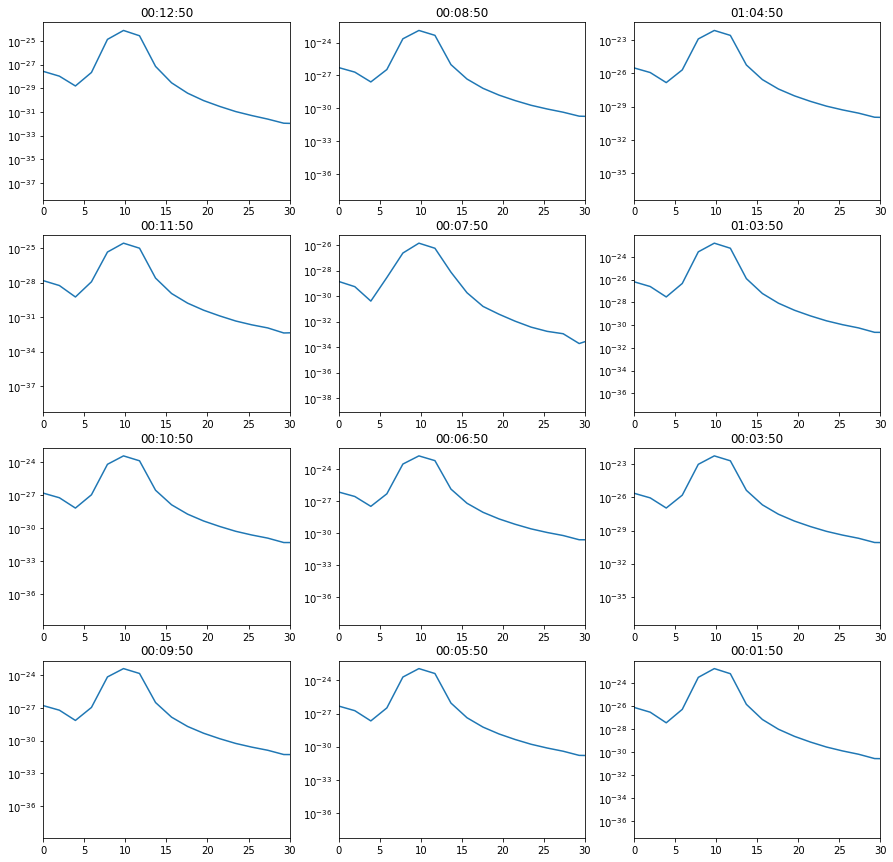

In [109]:
epo_mean = np.mean(epo_opm_f10, axis=1)

# # plot psd OPM data per channel
plt.figure(figsize=(15,15))
for i in range(num_primary_channels):

    f, pxx = signal.welch(epo_mean[i], fs, nperseg=512)
    plt.subplot(4,3,i+1)
    plt.title(channel_orders[i])
    plt.semilogy(f, pxx)
    plt.xlim(0,30)

    # pxx, f = psd_welch(raw, fmax=100, n_fft=1000, picks=channel_orders[i])
    # plt.semilogy(f, pxx.flatten())
    # plt.xlabel("freqs (Hz)")
    # plt.ylabel("Power")

# # %matplotlib inline
# plt.figure(figsize=(15,8))
# tmin = start_marker_index/fs
# tmax = end_marker_index/fs
# print(tmin)
# print(tmax)
# for i in range(num_primary_channels):
#     pxx, f = psd_welch(raw, fmin=0, fmax=250, n_fft=2048, picks=channel_orders[i], tmin=tmin, tmax=tmax)
#     plt.semilogy(f, pxx.flatten())
#     plt.xlabel("freqs (Hz)")
#     plt.ylabel("Power")


In [110]:
# ## prepare OPM data struct

# %matplotlib qt
# info = mne.create_info(list(channel_names), fs, list(channel_types))
# raw = mne.io.RawArray(opm_data_cut[:].T, info)

# ## plot/check reference data
# # ref_data = raw.pick_channels(ref_channels)[:][0]
# # print(ref_data.shape)
# # plt.plot(ref_data[0,:5000])
# # plt.plot(ref_data[1,:5000])
# # plt.plot(ref_data[2,:5000])


# ## Plot PSD of primary channels

# raw.drop_channels(ref_channels)
# raw.reorder_channels(channel_orders)

# # raw.filter(9,12)
# # raw.plot_psd(fmax=30)

# # plot psd OPM data per channel
# for i in range(len(channel_orders)):
#     pxx, f = psd_welch(raw, fmax=100, n_fft=1000, picks=channel_orders[i])
#     plt.subplot(4,3,i+1)
#     plt.semilogy(f, pxx.flatten())
#     plt.title(channel_orders[i])
#     plt.xlabel("freqs (Hz)")
#     plt.ylabel("Power")



Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 9 - 11 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 9.00
- Lower transition bandwidth: 2.25 Hz (-6 dB cutoff frequency: 7.88 Hz)
- Upper passband edge: 11.00 Hz
- Upper transition bandwidth: 2.75 Hz (-6 dB cutoff frequency: 12.38 Hz)
- Filter length: 1467 samples (1.467 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 9 - 11 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 9.00
- Lower transition bandwidth: 2.25 Hz (-6 dB cutoff frequency: 7.88 Hz)
- Upper passband edge:

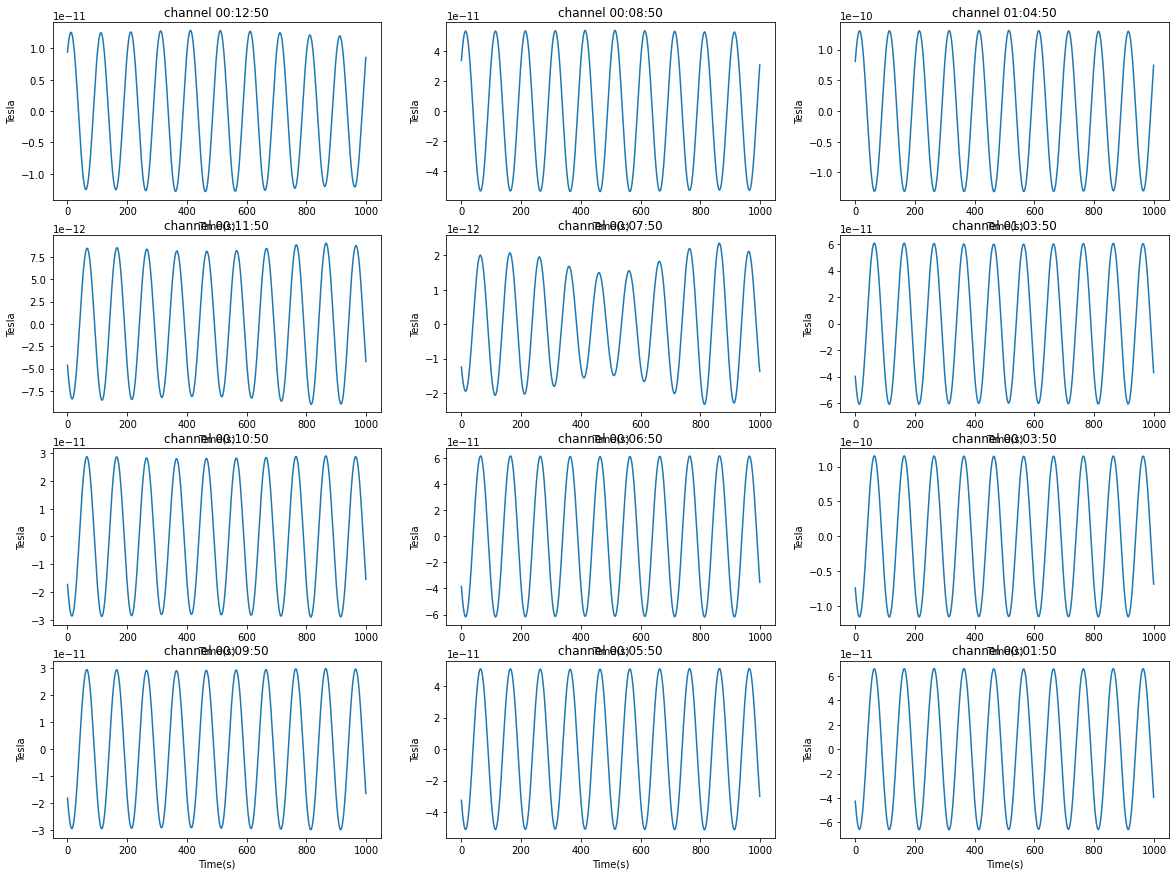

In [111]:
%matplotlib inline
# ## Plot time-series primary channels

# raw.filter(9,11)
# ref.filter(9,11)

# start_marker_index = 10000
# end_marker_index = 50000
raw_arr = raw.copy().filter(9,11).copy()[:][0][:, start_marker_index:end_marker_index]

ref_arr = ref.copy().filter(9,11).copy()[:][0][:, start_marker_index:end_marker_index]
print(ref_arr.shape)

print(raw_arr.shape)

start = 24000
end = 25000

# markers_line = adc_diode_markers[start:end].astype(bool)
# marker_ts = opm_time_stamps[start:end][markers_line]

# Visualize raw data with markers timestamps

plt.figure(figsize=(20,15))
for i in range(raw_arr.shape[0]): 
    plt.subplot(4,3,i+1)
    plt.title('channel ' + raw.ch_names[i])
    plt.plot(raw_arr[i, start:end])
    # plt.plot(ref_arr[0, start:end])
    # plt.plot(ref_arr[1, start:end])
    # plt.plot(ref_arr[2, start:end])


    # plt.ylim((-8e-9,8e-9))
    plt.ylabel('Tesla')
    plt.xlabel('Time(s)')
    # for ts in marker_ts:
    #     # print(time_stamps[j])
    #     plt.axvline(x=ts, c="red")





## Analyze phase information of visual stimuli and OPM data

No data channels found. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 9 - 11 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 9.00
- Lower transition bandwidth: 2.25 Hz (-6 dB cutoff frequency: 7.88 Hz)
- Upper passband edge: 11.00 Hz
- Upper transition bandwidth: 2.75 Hz (-6 dB cutoff frequency: 12.38 Hz)
- Filter length: 1467 samples (1.467 sec)



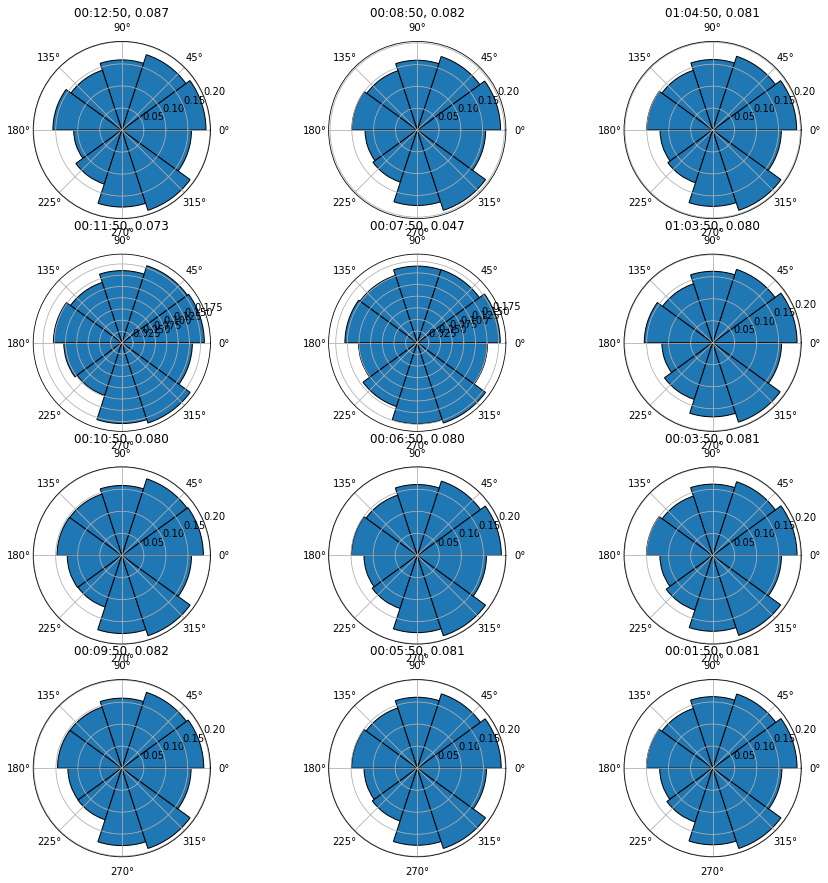

In [116]:
%matplotlib inline
def wrap(phases):
    return (phases + np.pi) % (2 * np.pi) - np.pi

def get_plv(phases):
    plv = (np.exp(1j*phases)).mean()
    return plv

def circ_detrend(phases): 
    # uses Euler's formula to get angle's vector, then get mean angle
    # plv = np.abs(np.sum(complex_phase_diff)/ len(phases))
    # plv= np.abs(np.sum(np.exp(1j*phases))) / len(phases)
    plv = get_plv(phases)
    mean = np.angle(plv)
    return plv, wrap(phases-mean) 




# ## check PLV in the whole time-series, which includes ITI 

# segment to start of experiment and end of experiment time 
raw_arr = raw_fil_10[:][0][:, start_marker_index:end_marker_index]

raw_pd_f10 = raw_photodiode.copy().filter(9,11, picks=photodiode_channel)[:][0][0][start_marker_index:end_marker_index]

flicker_stimulus_phase = np.angle(hilbert(raw_pd_f10), deg=False)

plt.figure(figsize=(15,15))
## for each channel
for i in range(raw_arr.shape[0]): 

    opm_angle = np.angle(hilbert(raw_arr[i]), deg=False)
    data = wrap(flicker_stimulus_phase-opm_angle)

    plt.subplot(4,3,i+1, polar=True)
    # ax.get_yaxis().set_visible(False)
    plv, detrend_data = circ_detrend(data)

    plt.hist(detrend_data,density=True,edgecolor='black')
    plt.title('%s, %.3f' % (raw.ch_names[i], np.abs(plv)))





In [113]:




# # plt.plot(raw_tacs[:][0][0,:50000])
# angle1 = np.angle(raw_tacs.copy().filter(39,41, picks=tACS_channel).apply_hilbert(envelope=True, picks=tACS_channel).filter(4,6, picks=tACS_channel).apply_hilbert(envelope=False, picks=tACS_channel)[:][0][0,start_marker_index:end_marker_index])


# plt.figure(figsize=(15,15))
# ## for each channel
# for i in range(raw_arr.shape[0]): 

#     opm_angle = np.angle(hilbert(raw_arr[i]), deg=False)
#     data = wrap(angle1-opm_angle)

#     plt.subplot(4,3,i+1, polar=True)
#     # ax.get_yaxis().set_visible(False)
#     plv, detrend_data = circ_detrend(data)

#     plt.hist(detrend_data,density=True,edgecolor='black')
#     plt.title('%s, %.3f' % (raw.ch_names[i], np.abs(plv)))

No data channels found. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 9 - 11 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 9.00
- Lower transition bandwidth: 2.25 Hz (-6 dB cutoff frequency: 7.88 Hz)
- Upper passband edge: 11.00 Hz
- Upper transition bandwidth: 2.75 Hz (-6 dB cutoff frequency: 12.38 Hz)
- Filter length: 1467 samples (1.467 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 9 - 11 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge

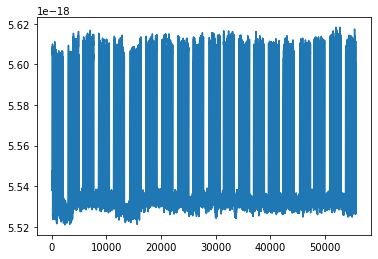

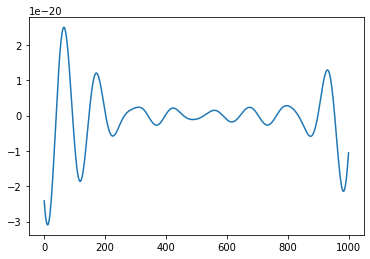

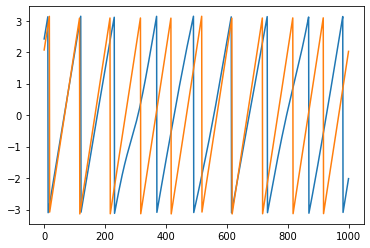

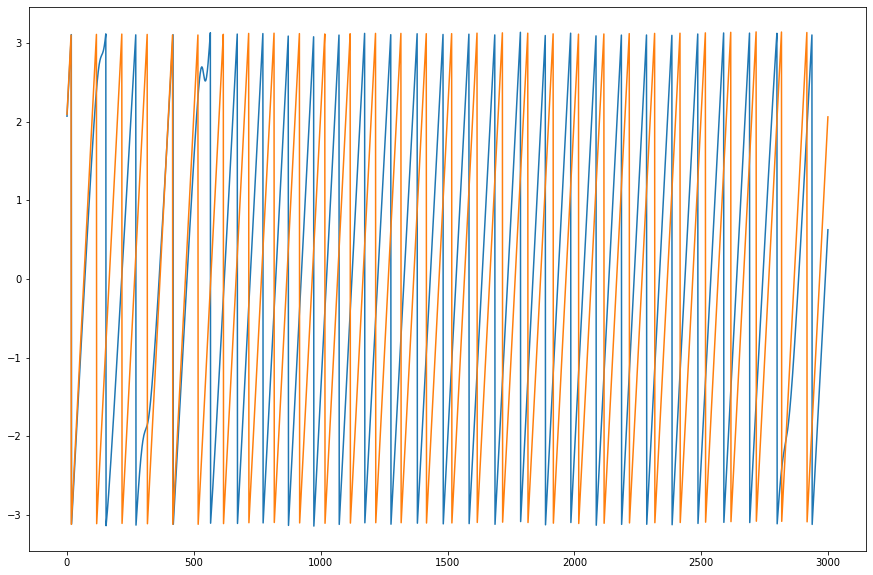

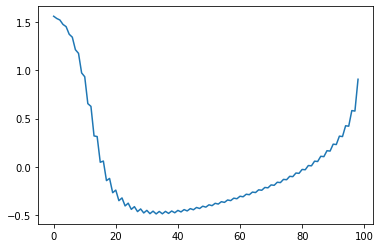

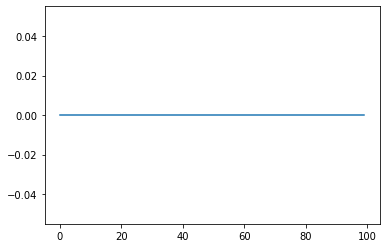

In [114]:


plt.figure()
x = raw_photodiode._data[0, start_marker_index:end_marker_index]
plt.plot(x[:])

x = raw_photodiode.copy().filter(9,11, picks=photodiode_channel)[:][0][0][start_marker_index:end_marker_index]
plt.figure()
plt.plot(x[2000:3000])
# x[2100:2650] = 0

x_angle = wrap(np.angle(hilbert(x)))
y = raw.copy().filter(9,11)[:][0][9, start_marker_index:end_marker_index]
y_angle = wrap(np.angle(hilbert(y)))

plt.figure()
plt.plot(x_angle[2000:3000])
plt.plot(y_angle[2000:3000])


plt.figure(figsize=(15,10))
plt.plot(x_angle[5000:8000])
plt.plot(y_angle[5000:8000])


plt.figure()
x = np.arange(1,100)
# plt.plot(x)
plt.plot(wrap(np.angle(hilbert(x))))


plt.figure()
x = np.ones(100)
# plt.plot(x)
plt.plot(wrap(np.angle(hilbert(x))))

Effective window size : 2.048 (s)


Text(0, 0.5, 'Magnectic field (T/$\\sqrt{Hz}$)')

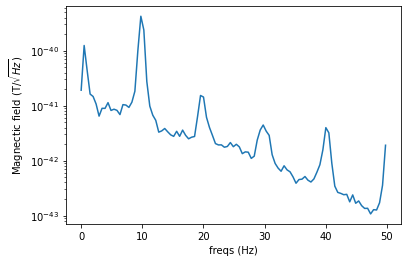

In [115]:
plt.figure()
# x = raw_photodiode.copy().filter(9,11, picks=photodiode_channel)[:][0][0][start_marker_index:end_marker_index]
x = raw_photodiode.copy()
pxx, f = psd_welch(x, fmin=0, fmax=50, n_fft=2048, picks=photodiode_channel)
# pxx_avg = np.mean(np.sqrt(pxx), axis=0)
plt.semilogy(f, pxx[0], label='2.5mA p2p')
plt.xlabel("freqs (Hz)")
plt.ylabel("Magnectic field (T/$\sqrt{Hz}$)")
# plt.plot(x[:1000])


